In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pmdarima import auto_arima
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import math
from datetime import datetime, timedelta
import os

In [2]:
combined = pd.read_csv('../data/processed/combined_data.csv', index_col='Date', parse_dates=True)
tsla_close = combined['TSLA']
end_date = (datetime.now() - timedelta(days=1)).strftime('%Y-%m-%d')

In [3]:
train = tsla_close['2015-07-01':'2023-12-31']
test = tsla_close['2024-01-01':end_date]

In [4]:
model_arima = auto_arima(train, seasonal=True, m=12)
arima_fit = ARIMA(train, order=model_arima.order, seasonal_order=model_arima.seasonal_order).fit()
arima_forecast = arima_fit.forecast(steps=len(test))
print('ARIMA Params:', model_arima.order, model_arima.seasonal_order)

C:\Project\Time-Series-Forecasting-Weeek11\venv\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Project\Time-Series-Forecasting-Weeek11\venv\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Project\Time-Series-Forecasting-Weeek11\venv\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Project\Time-Series-Forecasting-Weeek11\venv\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Project\Time-Series-Forecasting-Weeek11\venv\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: '

ARIMA Params: (1, 1, 2) (0, 0, 0, 12)


In [5]:
scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train.values.reshape(-1,1))
test_scaled = scaler.transform(test.values.reshape(-1,1))

def create_sequences(data, seq_length=60):
    xs, ys = [], []
    for i in range(len(data)-seq_length):
        xs.append(data[i:i+seq_length])
        ys.append(data[i+seq_length])
    return np.array(xs), np.array(ys)

X_train, y_train = create_sequences(train_scaled)
X_test, y_test = create_sequences(np.concatenate((train_scaled[-60:], test_scaled)))

model_lstm = Sequential()
model_lstm.add(LSTM(50, return_sequences=True, input_shape=(X_train.shape[1],1)))
model_lstm.add(LSTM(50))
model_lstm.add(Dense(1))
model_lstm.compile(optimizer='adam', loss='mean_squared_error')
model_lstm.fit(X_train, y_train, epochs=50, batch_size=32, verbose=1)

lstm_pred_scaled = model_lstm.predict(X_test)
lstm_forecast = scaler.inverse_transform(lstm_pred_scaled)[-len(test):]

C:\Project\Time-Series-Forecasting-Weeek11\venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
68/68 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - loss: 0.0066
Epoch 2/50
68/68 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 0.0012
Epoch 3/50
68/68 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 0.0012
Epoch 4/50
68/68 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 0.0010
Epoch 5/50
68/68 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 8.9079e-04
Epoch 6/50
68/68 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 7.7940e-04
Epoch 7/50
68/68 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 7.8449e-04
Epoch 8/50
68/68 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 7.2858e-04
Epoch 9/50
68/68 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 6.7210e-04
Epoch 10/50
68/68 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 5.9250e-04
Epoch 11/50
68/68 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 6.2120e-04
Epoch 12/50
68/68 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 5.5360e-04
Epoch 13/50
68/68 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 5.6242e-04
Epoch 14/50
68/68 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 4.8468e-04
Epoch 15/50
68/68 ━━━━━━━━━━━━━

In [6]:
def evaluate(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = math.sqrt(mean_squared_error(y_true, y_pred))
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    return mae, rmse, mape

arima_mae, arima_rmse, arima_mape = evaluate(test, arima_forecast)
lstm_mae, lstm_rmse, lstm_mape = evaluate(test, lstm_forecast.flatten())

print(f'ARIMA: MAE={arima_mae}, RMSE={arima_rmse}, MAPE={arima_mape}')
print(f'LSTM: MAE={lstm_mae}, RMSE={lstm_rmse}, MAPE={lstm_mape}')

ARIMA: MAE=64.25799219791983, RMSE=77.98555581253449, MAPE=24.980711923676104
LSTM: MAE=7.926126025971913, RMSE=11.486969814747358, MAPE=2.9776352588601744


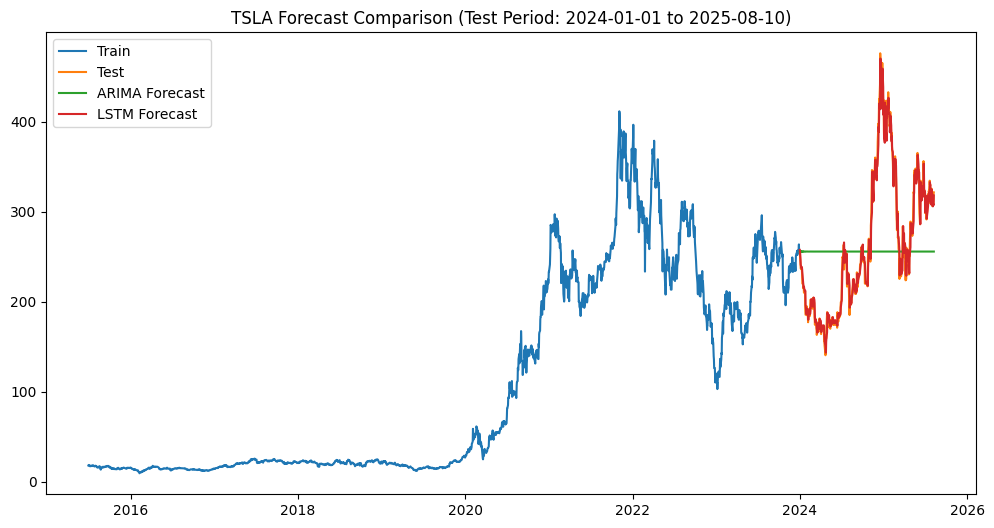

In [7]:
plt.figure(figsize=(12,6))
plt.plot(train, label='Train')
plt.plot(test, label='Test')
plt.plot(test.index, arima_forecast, label='ARIMA Forecast')
plt.plot(test.index, lstm_forecast, label='LSTM Forecast')
plt.title(f'TSLA Forecast Comparison (Test Period: 2024-01-01 to {end_date})')
plt.legend()
plt.savefig('../reports/figures/forecast_comparison.png')
plt.show()

In [8]:
pd.Series(arima_forecast, index=test.index).to_csv('../data/processed/arima_forecast.csv')
pd.Series(lstm_forecast.flatten(), index=test.index).to_csv('../data/processed/lstm_forecast.csv')
model_lstm.save('lstm_model.h5')